# CSCI 3202, Fall 2025
### Homework 3
### Points: 110
### Due: Wednesday, September 17, 2025

<br> 

## Your name: Abdullah Yassine

<br>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import deque
import heapq

---
## Problem 1

### Discrete Robot Path Planning

A robotics group at CU needs some help designing a path planning algorithm that can navigate around the engineering center. To get started they have designed two test environments for you to implement breadth-first, depth-first, and uniform-cost search.

- In the first environment, every movement to an adjacent cell has a cost of 1. The first environment will be represented by the `edge_weights_1` dictionary. 

- In the second enviornment, traveling to adjacent cells has a random int cost between 1 and 100. The second environment will be represented by the `edge_weights_2` dictionary. 

- Both setups have the same obstacles, free space, and goal. The code below creates and gives a visual representation of the robot's environment. 

- The first figure shows the environment itself with free spaces, barriers, robot start, and goal point. 

- The second image shows an example of what a path might look like as the robot moves through the environment.

### Color representation
yellow = obstacle

teal = free space

pink = goal

grey = robot start

red = part of the path

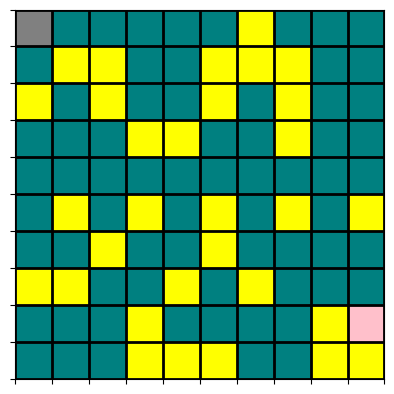

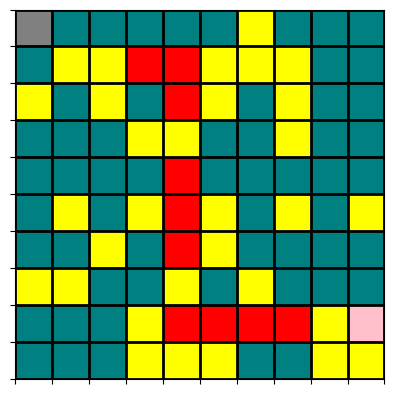

In [2]:
# Given code
def show_path(env, path):
    env_copy = np.copy(env)
    for cell in path:
        if(env_copy[cell[0]][cell[1]] >= 5 and env_copy[cell[0]][cell[1]] < 20):
            env_copy[cell[0]][cell[1]] = 41
    show_env(env_copy)
    
        
def show_env(env):
    cmap = colors.ListedColormap(['yellow', 'teal', 'pink', 'grey', 'red'])
    bounds = [0,5,20,30,40,41]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(env, cmap=cmap, norm=norm)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, 10, 1));
    ax.set_yticks(np.arange(-.5, 10, 1));
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    plt.show()
    
    

np.random.seed(303)
env = np.random.rand(10, 10) * 20
#set robot start position, grey color spot
start = (0, 0)
env[start[0]][start[1]] = 31

#set goal position pink square
goal = (8, 9)

env[goal[0]][goal[1]] = 21

# show the original graph
show_env(env)

# show an example path in the original graph, not a valid path
# Note: the path prints as red only if there isn't an obstacle there.
example_path = [(1,1), (1,2), (1,3), (1,4), (2,4), (3,4), (4,4), (5,4), (6,4), (7,4), (8,4), (8,5),(8,6),(8,7),(8,8)]
show_path(env, example_path)

### Graph Representation
We represent the graph above as an adjacency dict in the following code. You can see what edges any cell has by indexing into the two dicts: 
- `edge_weights_1`
- `edge_weights_2`

For indexing, the top left of the graph is (row=0, col=0). Row values increase downward and column values increase to the right. 

So for example, if you wanted to look at the pink cell's (the goal location) connections you can call `print(edge_weights_2[(8,9)])` 

In [3]:
# create dictionary
edge_weights_1 = {}
edge_weights_2 = {}

for row, row_vals in enumerate(env):
    for col, val in enumerate(env[row]):
        # create dictionary
        edge_weights_1[(row, col)] = {}
        edge_weights_2[(row, col)] = {}
            
        #set all 6 direction options in edge_wights
        # 1) up
        if(row > 0):
            edge_weights_1[(row, col)][(row-1, col)] = 1
            edge_weights_2[(row, col)][(row-1, col)] = np.random.randint(101)
            if(col > 0):
                edge_weights_1[(row, col)][(row-1, col-1)] = 1
                edge_weights_2[(row, col)][(row-1, col-1)] = np.random.randint(101)
            if(col < 9):
                edge_weights_1[(row, col)][(row-1, col+1)] = 1
                edge_weights_2[(row, col)][(row-1, col+1)] = np.random.randint(101)
                
                
        #2) left
        if(col > 0):
            edge_weights_1[(row, col)][(row, col-1)] = 1
            edge_weights_2[(row, col)][(row, col-1)] = np.random.randint(101)
            if(row < 9):
                edge_weights_1[(row, col)][(row+1, col-1)] = 1
                edge_weights_2[(row, col)][(row+1, col-1)] = np.random.randint(101)
                
        #3) down 
        if(row < 9):
                edge_weights_1[(row, col)][(row+1, col)] = 1
                edge_weights_2[(row, col)][(row+1, col)] = np.random.randint(101)
                if(col < 9): 
                    edge_weights_1[(row, col)][(row+1, col+1)] = 1
                    edge_weights_2[(row, col)][(row+1, col+1)] = np.random.randint(101)
        
        #) right
        if(col < 9):
                edge_weights_1[(row, col)][(row, col+1)] = 1
                edge_weights_2[(row, col)][(row, col+1)] = np.random.randint(101)

for first_node in list(edge_weights_2.keys()):
    for second_node in list(edge_weights_2[first_node].keys()):
        
        # if first_node is yellow (an obstacle) the connection going both ways should be removed
        if(env[first_node[0]][[first_node[1]]] < 5):
            edge_weights_2[first_node].pop(second_node)
            edge_weights_2[second_node].pop(first_node)
            edge_weights_1[first_node].pop(second_node)
            edge_weights_1[second_node].pop(first_node)
        # if there is a connection, make sure both edges are the same
        else:
            w1 = edge_weights_2[first_node][second_node]
            w2 = edge_weights_2[second_node][first_node]
            if(w1 != w2):
                edge_weights_2[first_node][second_node] = edge_weights_2[second_node][first_node]
                
                
# These represent the same location
print('goal:   ', edge_weights_2[goal])
print('(8, 9): ', edge_weights_2[(8,9)])

goal:    {(7, 9): 11, (7, 8): 1}
(8, 9):  {(7, 9): 11, (7, 8): 1}


### Useful helper routines for searching


In [4]:
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

def pathcost(path, step_costs):
    '''
    add up the step costs along a path, which is assumed to be a list output from the `path` function above
    '''
    cost = 0
    for s in range(len(path)-1):
        cost += step_costs[path[s]][path[s+1]]
    return cost

In [5]:
def check_map(step_costs):
    ''' function to check if all the path costs are at least symmetric '''
    check_states = []
    for state1 in step_costs.keys():
        for state2 in step_costs[state1].keys():
            uh_oh = step_costs[state2][state1]!=step_costs[state1][state2]
            if uh_oh:
                print('Check the costs between states {} and {}'.format(state1,state2))
                check_states.append([state1,state2])
    if len(check_states)==0:
        print('all okay! (symmetric at least)')
    return check_states

---
### 1(a) (10 points)

#### Breadth-first search

Implement a function **breadth_first(start, goal, state_graph, return_cost)** to search the state space defined by the **state_graph** using breadth-first search:
* **start**: initial state (e.g., '(0,0)' or `start`)
* **end**: goal state (e.g., '(8,9)' or `goal`)
* **state_graph**: the dictionary defining the edge costs (e.g., `edge_weights_1` or `edge_weights_2`)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path as tuples (row, col) and the second value is the path cost
  * If **False**, then the only output is the solution path list object

Note that in the helper functions above, two useful routines for obtaining your solution path are provided (and can be used for all the search algorithms):
  * **path(previous, s)**: returns a list representing a path to state **s**, where **previous** is a dictionary that maps predecessors (values) to successors (keys)
  * **pathcost(path, step_costs)**: adds up the step costs defined by the **step_costs** graph (e.g., `edge_weights_2`) along the list of states **path**

In [6]:
# Your solution here
from collections import deque
def breadth_first(start, goal, state_graph, return_cost):
    if start not in state_graph or goal not in state_graph:
        return []
    if start == goal:
        if return_cost == True:
            return [start], 0
        return [start]
    
    frontier = deque()
    visited = set()
    previous = {} # dict saving who visited what
    previous[start] = None
    
    frontier.append(start)
    visited.add(start)
    while frontier:
        popped =frontier.popleft()

        if popped == goal:
            path_list = path(previous, goal)
            if return_cost == True:
                return path_list, pathcost(path_list, state_graph)
            else:
                return path_list
        for neighbor in state_graph[popped].keys():
            if neighbor not in visited:
                frontier.append(neighbor)
                previous[neighbor] = popped
                visited.add(neighbor)
        
    return [] if not return_cost else ([], None)
    

    

---
### 1(b) (10 points)

#### Uniform-cost search

First, let's create our own `Frontier_PQ` class to represent the frontier (priority queue) for uniform-cost search.  Note that the `heapq` package is imported in the helpers at the bottom of this notebook; you may find that package useful.  You could also use the `Queue` package.  Your implementation of the uniform-cost search frontier should adhere to these specifications:
* Instantiation arguments: 
  * **Frontier_PQ(start, cost)**
  * **start** is the initial state (e.g., **start**=(0,0) or `start`)
  * **cost** is the initial path cost (what should it be for the initial state?)
* Instantiation attributes/methods:
  * **states**: maintains a dictionary of states on the frontier, along with the _minimum_ path cost to arrive at them
  * **q**: a list of (cost, state) tuples, representing the elements on the frontier; should be treated as a priority queue (in contrast to the **states** dictionary, which is meant to keep track of the lowest-cost to each state)
  * appropriately initialize the starting state and cost
* Methods to implement:
  * **add(state, cost)**: add the (cost, state) tuple to the frontier
  * **pop()**: return the lowest-cost (cost, state) tuple, and pop it off the frontier
  * **replace(state, cost)**: if you find a lower-cost path to a state that's already on the frontier, it should be replaced using this method.
  
Note that there is some redundancy between the information stored in **states** and **q**. We only suggest to code it in this way because we think it's the most straightforward way to get something working. You could reduce the storage requirements by eliminating the redundancy, but it increases the time complexity because of the function calls needed to manipulate your priority queue to check for states (since that isn't how the frontier queue is ordered).

In [7]:
# Your solution 
class Frontier_PQ():
    def __init__(self, start, cost):
        self.start  = start
        self.cost = cost
        self.states = {start : cost} # dict[tuples] : cost
        self.q = [(cost, start)] # priority queue of tuples
        heapq.heapify(self.q)

    def add(self, state, cost):
        """
        
        """
        heapq.heappush(self.q, (cost, state))
        self.states[state] = cost

    def pop(self):
        while self.q:
            cost, state = heapq.heappop(self.q)

            if self.states.get(state) == cost:
                del self.states[state]
                return cost, state
        return None
    def replace(self, state, cost):
        self.states[state] = cost
        heapq.heappush(self.q, (cost, state))

Now, actually implement a function to search using `uniform_cost` search, called as **uniform_cost(start, goal, state_graph, return_cost)**:
* **start**: initial state
* **goal**: goal state
* **state_graph**: graph representing the connectivity and step costs of the state space (e.g., **edge_weights_1** or **edge_weights_2**)
* **return_cost**: logical input representing whether or not to return the solution path cost
  * If **True**, then the output should be a tuple where the first value is the list representing the solution path and the second value is the path cost
  * If **False**, then the only output is the solution path list object

In [8]:
# Your solution 
def uniform_search(start, goal, state_graph, return_cost):
    if start not in state_graph or goal not in state_graph:
        return []
    if start == goal:
        if return_cost == True:
            return [start], 0
        return [start]
    pq = Frontier_PQ(start, 0)
    visited = set()
    previous = {start : None} 
    while pq.q:
        cost, state = pq.pop()
        if state in visited: continue
        visited.add(state)
        if state == goal:
            path_list = path(previous, goal)
            if return_cost == True:
                return path_list, pathcost(path_list, state_graph)
            else:
                return path_list

        for neighbor, n_cost in state_graph[state].items():
            if neighbor not in visited:
                if neighbor not in pq.states or cost + n_cost < pq.states[neighbor]:
                    pq.replace(neighbor, cost + n_cost)
                    previous[neighbor] = state
    return [] if not return_cost else ([], None)
                    


---

### 1(c) (30 points)

In the code cell below, for each of the two search algorithms defined above (in **1a** and **1b**), display the following information to the screen:

First, use `edge_weights_1`:
1) Print the path from start to goal 
2) Print the total cost of that path
3) Use the `show_path(env, path)` function to showcase the output your search algorithm. 

Second, use `edge_weights_2`:
1) Print the path from start to goal 
2) Print the total cost of that path
3) Use the `show_path(env, path)` function to showcase the output your search algorithm. 


Then, in a markdown cell below your code cell, write a few sentences:
* Which algorithm yields the shortest path for both edge weights?
* Does this surprise you? Or is this your expected result?

BFS path from (0, 0) to (9, 6) is: [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5), (8, 5), (9, 6)] 
BFS total cost of the path: 9
Here is the output of BFS algorithm:


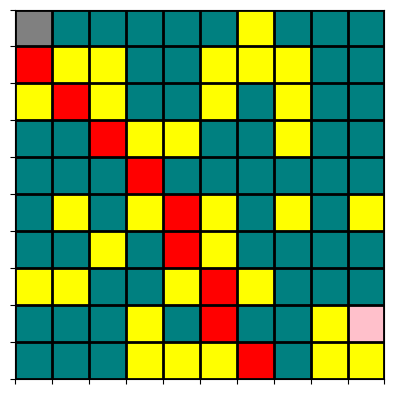

****************************************************************
UCS path from (0, 0) to (9, 6) is: [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5), (8, 5), (9, 6)] 
UCS total cost of the path: 9
Here is the output of UCS algorithm:


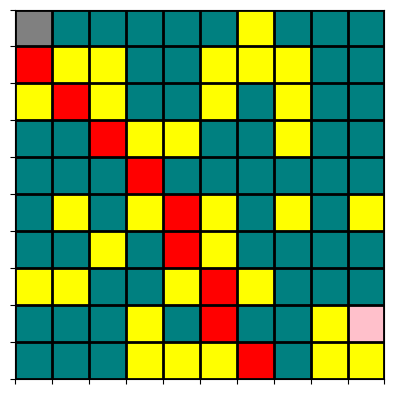

In [9]:
# Your solution here
start = (0,0)
goal = (9,6)
path_bfs, cost_bfs = breadth_first(start, goal, edge_weights_1, True)
print(f"BFS path from {start} to {goal} is: {path_bfs} ")
print(f"BFS total cost of the path: {cost_bfs}")
print("Here is the output of BFS algorithm:")
show_path(env, path_bfs)

print("****************************************************************")
path_ucs, cost_ucs = uniform_search(start, goal, edge_weights_1, True)
print(f"UCS path from {start} to {goal} is: {path_ucs} ")
print(f"UCS total cost of the path: {cost_ucs}")
print("Here is the output of UCS algorithm:")
show_path(env, path_ucs)


BFS path from (0, 0) to (9, 6) is: [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5), (8, 5), (9, 6)] 
BFS total cost of the path: 493
Here is the output of BFS algorithm:


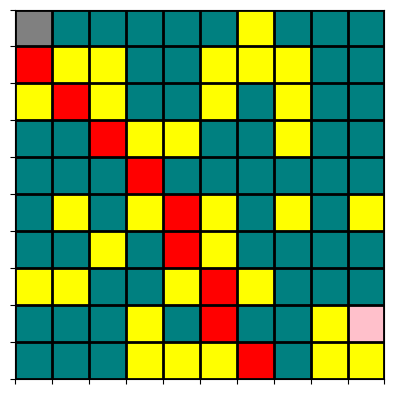

****************************************************************
UCS path from (0, 0) to (9, 6) is: [(0, 0), (1, 0), (2, 1), (3, 0), (3, 1), (4, 0), (5, 0), (6, 1), (7, 2), (7, 3), (8, 4), (7, 5), (8, 5), (9, 6)] 
UCS total cost of the path: 380
Here is the output of UCS algorithm:


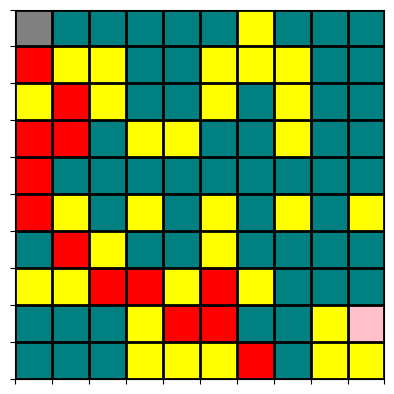

In [10]:
# Your solution here
start = (0,0)
goal = (9,6)
path_bfs, cost_bfs = breadth_first(start, goal, edge_weights_2, True)
print(f"BFS path from {start} to {goal} is: {path_bfs} ")
print(f"BFS total cost of the path: {cost_bfs}")
print("Here is the output of BFS algorithm:")
show_path(env, path_bfs)

print("****************************************************************")
path_ucs, cost_ucs = uniform_search(start, goal, edge_weights_2, True)
print(f"UCS path from {start} to {goal} is: {path_ucs} ")
print(f"UCS total cost of the path: {cost_ucs}")
print("Here is the output of UCS algorithm:")
show_path(env, path_ucs)

Which algorithm yields the shortest path for both edge weights?

**Answer**: For `edge_weights_1`, both yielded the shortest path because the edge weights are all 1, so in this case, UCS acts exactly the same as BFS if the weights are all 1. For `edge_weights_2`, when edge weights are applied, BFS yielded the shortest path in the sense it had to go through fewer nodes than UCS. However, UCS yeilded the shortest path because it had the lowest total cost.

Does this surprise you? Or is this your expected result?

**Answer**: This did not surprise me because BFS is expected to behave this way: it does not care about the weights, but it will return the smallest number of nodes it'll go through *regardless* of the weights. This is the shortest path if the edge weights are all the same, but not the shortest path if otherwise. UCS gives you the shortest path given the edged weights.

---
## Problem 2: A*
Use the graph below to go through the A* algorithm by hand to determine the path that should be taken from $A$ to $G$. Heuristic values are shown in purple near each node. Step costs between nodes are shown near each respective edge in green.

<div>
<img src="AStar Graph.png" width="35%"/>
</div>

### 2(a) (10 points)
Create a table in the cell below showing the Step (each time you pop a node from the stack create a new step), the Frontier with the estimated path cost for each node (path cost to each node plus the estimated cost from the node to the goal), a list of explanded nodes, and an action list showing which node was expanded and the nodes that were visited due to that expansion.  If there are any ties, break them in alphabetical order.

## A Answer

**Heuristics:**  
- A = 8  
- B = 5  
- C = 5  
- D = 4  
- E = 4  
- F = 4  
- G = 0  

**Edges:**  
- A–B = 2, A–C = 4  
- B–D = 6  
- C–E = 3, C–F = 2  
- D–E = 3, D–G = 5  
- E–F = 2, E–G = 4  
- F–G = 4  

---

### Step-by-Step A* Trace

| Step | Popped (expanded) | Frontier (node : f = g + h) | Expanded so far | Action list (new neighbors discovered/updated) |
|------|--------------------|-----------------------------|-----------------|------------------------------------------------|
| 1    | **A**              | B: **7** (=2+5), C: **9** (=4+5) | A               | Discovered B, C |
| 2    | **B**              | C: **9**, D: **12** (=8+4) | A, B            | Discovered D |
| 3    | **C**              | F: **10** (=6+4), E: **11** (=7+4), D: **12** | A, B, C | Discovered E, F |
| 4    | **F**              | G: **10** (=10+0), E: **11**, D: **12** | A, B, C, F | Discovered G |
| 5    | **G** (goal)       | E: **11**, D: **12** | A, B, C, F, G | — |

---

### Conclusion
- **Optimal path:** A → C → F → G  
- **Total path cost (g):** 4 (A→C) + 2 (C→F) + 4 (F→G) = **10**  
- A* stops when G is popped because it is the goal with the lowest f.  



In [11]:
# Your solution here
import pandas as pd

rows = [
    {"Step": 1, "Popped": "A", "Frontier": "B:7, C:9", "Expanded": "A", "Action": "Discovered B, C"},
    {"Step": 2, "Popped": "B", "Frontier": "C:9, D:12", "Expanded": "A, B", "Action": "Discovered D"},
    {"Step": 3, "Popped": "C", "Frontier": "F:10, E:11, D:12", "Expanded": "A, B, C", "Action": "Discovered E, F"},
    {"Step": 4, "Popped": "F", "Frontier": "G:10, E:11, D:12", "Expanded": "A, B, C, F", "Action": "Discovered G"},
    {"Step": 5, "Popped": "G (goal)", "Frontier": "E:11, D:12", "Expanded": "A, B, C, F, G", "Action": "—"},
]

df = pd.DataFrame(rows)
df

,Step,Popped,Frontier,Expanded,Action
0,1,A,"B:7, C:9",A,"Discovered B, C"
1,2,B,"C:9, D:12","A, B",Discovered D
2,3,C,"F:10, E:11, D:12","A, B, C","Discovered E, F"
3,4,F,"G:10, E:11, D:12","A, B, C, F",Discovered G
4,5,G (goal),"E:11, D:12","A, B, C, F, G",—


### 2(b) (5 points)
What is the final path chosen by the algorithm?  What is the path cost?

In [12]:
# Your solution here
final_path = ["A", "C", "F", "G"]

# total path cost (A->C = 4, C->F = 2, F->G = 4)
path_cost = 4 + 2 + 4

print("Final Path:", final_path)
print("Path Cost:", path_cost)

Final Path: ['A', 'C', 'F', 'G']
Path Cost: 10


### 2(c) - robot path planning (20 points)

Using the robot environment in Problem 1, implement the A* algorithm using a Euclidean distance heuristic. In this implementation $h(n) = \sqrt{(x_g - x_n)^2 + (y_g - y_n)^2}$. In this equation; $x_g$ and $x_n$ represent the column location of goal and current node, repectively. The variables $y_g$ and $y_n$ are the row values of each node.

Run your code and display the results visually using the `show_path` method.



In [13]:
# Your A* and heuristic code here
def a_star(start, goal, state_graph, return_cost):
    if start not in state_graph or goal not in state_graph:
        return []
    if start == goal:
        if return_cost == True:
            return [start], 0
        return [start]
    pq = Frontier_PQ(start, 0)
    visited = set()
    previous = {start : None} 
    g_costs = {start : 0}
    while pq.q:
        cost, state = pq.pop()
        if state in visited: continue
        visited.add(state)
        if state == goal:
            path_list = path(previous, goal)
            if return_cost == True:
                return path_list, g_costs[state]
            else:
                return path_list

        for neighbor, n_cost in state_graph[state].items():
            if neighbor not in visited:
                euclidean_h = ((goal[0] - neighbor[0])**2 + (goal[1] - neighbor[1])**2)**0.5
                if neighbor not in pq.states or g_costs[state] + n_cost + euclidean_h < pq.states[neighbor]:
                    pq.replace(neighbor, g_costs[state] + n_cost + euclidean_h)
                    previous[neighbor] = state
                    g_costs[neighbor] = g_costs[state] + n_cost
    return [] if not return_cost else ([], None)

---------------------------------
A* solution edge_weights_1:  ([(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 4), (7, 5), (8, 6), (8, 7), (7, 8), (8, 9)], 11)
---------------------------------
A* solution edge_weights_2: ([(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (4, 4), (5, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)], 404)
---------------------------------


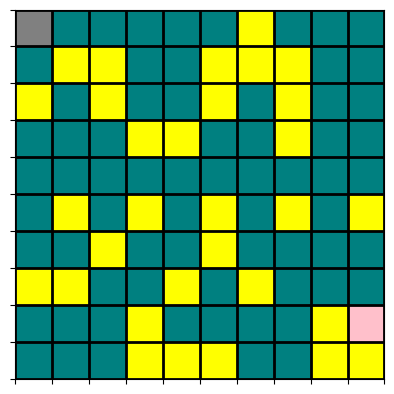

A* edge_weights_1


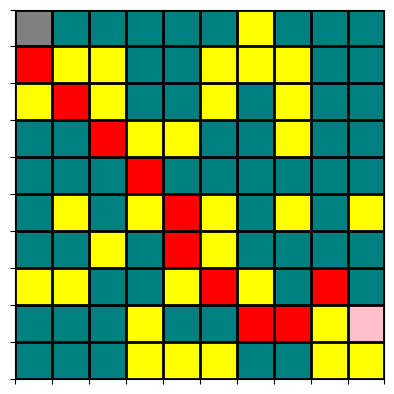

A* edge_weights_2


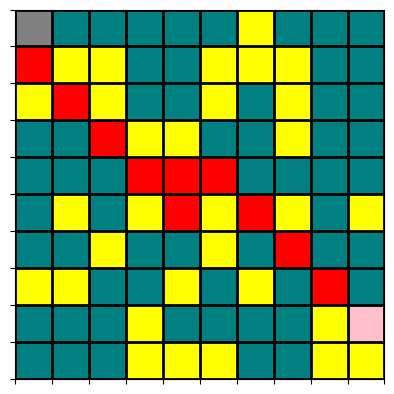

In [14]:
# Next we show the solution paths for edge_weights_2
start = (0,0)
goal = (8,9)
graph_1 = edge_weights_1
graph_2 = edge_weights_2
a_star_ret_1 = a_star(start, goal, graph_1, True)
a_star_ret_2 = a_star(start, goal, graph_2, True)

print("---------------------------------")
print("A* solution edge_weights_1: ", a_star_ret_1)
print("---------------------------------")
print("A* solution edge_weights_2:", a_star_ret_2)
print("---------------------------------")



show_env(env)
print('A* edge_weights_1')
show_path(env, a_star_ret_1[0])
print('A* edge_weights_2')
show_path(env, a_star_ret_2[0])

### 2(d) (10 points)
Explain what benefits this algorithm has over bfs, dfs, and ucs, generally speaking, and how the results compare to your results for bfs and ucs implemented in Question 1.

A* has several key advantages over BFS, DFS, and UCS. It is optimal (always finds the lowest-cost path), complete (guaranteed to find a path if one exists), and optimally efficient (no other search will expand fewer nodes under the same conditions).

While BFS and DFS are complete, they do not guarantee the optimal path and often waste time exploring more nodes. UCS does guarantee an optimal path when all edge costs are positive, but A* is generally more efficient because it expands fewer nodes by leveraging its heuristic.

---
## Problem 3 - Heuristics

For questions 3A, 3B, and 3C answer True or False and provide a brief explanation, or a counterexample where applicable.

### Part 3(a) (5 points) 
Depth-first search always expands at least as many nodes as A* search with an admissible heuristic.

### Part 3(b) (5 points) 
Uniform cost search always expands at least as many nodes as A* search with an admissible heuristic.


### Part 3(c) (5 points)
In the game of chess, in a single move, a rook can move any number of squares on a chessboard in a straight line, either vertically or horizontally, but cannot jump over other pieces. Manhattan distance is an admissible heuristic for the smallest number of moves required to move the rook from square A to square B.



### Part 3(a) Answer

False.

Depth-first search does not necessarily expand at least as many nodes as A*. While A* with an admissible heuristic is **optimal** and generally more efficient, DFS can sometimes get lucky and reach the goal on its first branch, expanding fewer nodes. For example, if the goal is the first child explored from the initial state, DFS will only expand the start and the goal, whereas A* (with h=0) will expand the start and both of its children.

### Part 3(b) Answer

True.

Uniform-cost search **always** expands at least as many nodes as A* with an admissible heuristic. UCS expands nodes based only on **path cost**, while A* considers **both** path cost and a heuristic. Since an admissible heuristic never overestimates the true cost, A* is guaranteed to expand no more nodes than UCS. In the worst case, when the heuristic is h = 0, A* behaves exactly the same as UCS.

### Part 3(b) Answer

False.

Manhattan distance (|x₂ - x₁| + |y₂ - y₁|) **is not admissible** because it **overestimates** the number of moves for a rook. A rook can move any number of squares in a straight line in a single move; for example, from **a1 → h1** on an empty board, the true cost is **1**, while the Manhattan distance is **7**. Since an admissible heuristic must **never** overestimate the actual cost, the Manhattan distance is not admissible for determining the rook’s minimum moves.


